In [15]:
from Tools.utils import *
import scipy.io as sio  # for loading matlab matrices (Geodesic Distance)

In [43]:
# Zoomout parameters
# We put standard parameters as comments on the right
k_init = 4    # 4
k_step = 1    # 1
k_final = 20  # 50  (takes time)
N_inter = 10  # 10
#


pairs = np.stack([np.arange(1,49), np.zeros(48)]).T.astype(int)
pairs = np.concatenate([pairs, [[10,45],[17,45]]])
#

errs = []
errs2 = []
errs3 = []
errs4 = []
for p in pairs:
    i1 = p[0]
    i2 = p[1]
    #if i1 > 5: break # to get only part of the pairs

    ###
    datafolder = 'data/SMAL_r/'
    arr_files = np.loadtxt(datafolder + 'mesh_names.txt', dtype=np.str)
    filename1 = join(datafolder,arr_files[i1]+'.obj')
    filename2 = join(datafolder,arr_files[i2]+'.obj')

    ## load (and save) spectral data
    k = 50
    ## compute real and complex eigenvectors
    X = mesh(filename1, spectral=k)
    Y = mesh(filename2, spectral=k)
    #
    X.complex_spectral(k=k)
    Y.complex_spectral(k=k)

    # vts for gt correspondence
    vts_folder = 'cor'
    X.get_vts(cor_folder=vts_folder); Y.get_vts(cor_folder=vts_folder)
    
    # here we use oriented Diracs for Q->p2p
    X.gradv = X.grad_vert_op(); Y.gradv = Y.grad_vert_op();
    #X.gpdir = X.div_c_vert_op()@X.ceig; Y.gpdir = Y.div_c_vert_op()@Y.ceig
    X.gpdir = X.ceig; Y.gpdir = Y.ceig
    
    # compute ground truth with vts
    kgt = 50
    C12_gt = np.linalg.pinv(Y.eig[Y.vts,:kgt]) @ X.eig[X.vts, :kgt]
    T12_gt = fMap2pMap(Y.eig, X.eig, C12_gt.T)
    
    # save gt if necessary
    #mapsave = join(datafolder, 'maps_res', '{}_{:d}-{:d}.map')
    #np.savetxt(mapsave.format('GT',i1+1, i2+1), T12_gt,fmt="%i")
    #continue
    
    print('**', p, '**')
    
    map_name = 'maps_ini/{:d}_{:d}_ini.map'
    T12_ini = np.loadtxt(join(datafolder, map_name.format(i1+1,i2+1))).astype(int) - 1
    #
    C21_ini = pMap2fMap(X.eig[:,:k_init], Y.eig[:,:k_init], T12_ini)
    C12_ini = C21_ini.T


    ##
    C12, C21 = func_bijective_zm_fmap(X, Y, C12_ini, C21_ini, k_init=k_init,
                                      k_step=k_step, k_final=k_final, N_inter=N_inter,
                                      w1=1 ,w2=1, w3=0,
                                      wQ=0,verbose=-1)

    C12_2, C21_2 = func_bijective_zm_fmap(X, Y, C12_ini, C21_ini, k_init=k_init,
                                      k_step=k_step, k_final=k_final, N_inter=N_inter,
                                      w1=1 ,w2=1, w3=1,
                                      wQ=0,verbose=-1)


    C12_3, C21_3 = func_bijective_zm_fmap(X, Y, C12_ini, C21_ini, k_init=k_init,
                                      k_step=k_step, k_final=k_final, N_inter=N_inter,
                                      w1=1 ,w2=1, w3=0,
                                      wQ=1,verbose=-1)


    C12_4, C21_4 = func_bijective_zm_fmap(X, Y, C12_ini, C21_ini, k_init=k_init,
                                      k_step=k_step, k_final=k_final, N_inter=N_inter,
                                      w1=1, w2=1, w3=1,
                                      wQ=1,verbose=-1)

    # you can also compare standard Zoomout (or other variant of the algorithm)

#     C21_3 = func_zm_fmap(X,Y,C21_ini,k_init=k_init,
#                     k_step=k_step, k_final=k_final, N_inter=N_inter,
#                     wQ=0)

#     C21_4 = func_zm_fmap(X,Y,C21_ini,k_init=k_init,
#                     k_step=k_step, k_final=k_final, N_inter=N_inter,
#                     wQ=1)



    mapsave = join(datafolder, 'maps_res', '{}_{:d}-{:d}.map')

    T12 = fMap2pMap(Y.eig, X.eig, C21)
    np.savetxt(mapsave.format('bij',i1+1, i2+1), T12,fmt="%i")

    T12_2 = fMap2pMap(Y.eig, X.eig, C21_2)
    np.savetxt(mapsave.format('bij_iso',i1+1, i2+1), T12_2,fmt="%i")

    T12_3 = fMap2pMap(Y.eig, X.eig, C21_3)
    np.savetxt(mapsave.format('bij_Q',i1+1, i2+1), T12_3,fmt="%i")
    #np.savetxt(mapsave.format('zo',i1+1, i2+1), T12_3,fmt="%i")

    T12_4 = fMap2pMap(Y.eig, X.eig, C21_4)
    np.savetxt(mapsave.format('bij_iso_Q',i1+1, i2+1), T12_4,fmt="%i")
    #np.savetxt(mapsave.format('zo_Q',i1+1, i2+1), T12_4,fmt="%i")

    err = euc_err(Y, T12, T12_gt)
    err2 = euc_err(Y, T12_2, T12_gt)
    err3 = euc_err(Y, T12_3, T12_gt)
    err4 = euc_err(Y, T12_4, T12_gt)

    print('B', err)
    print('BI', err2)
    print('BQ', err3)
    print('BIQ', err4)

    errs += [err]
    errs2 += [err2]
    errs3 += [err3]
    errs4 += [err4]

** [1 0] **
B 0.15029991335374948
BI 0.13372019162591187
BQ 0.09810872052924345
BIQ 0.029952140452702922
** [2 0] **
B 0.14751916364380707
BI 0.1298738766584807
BQ 0.09549277415523029
BIQ 0.02653669079368254
** [3 0] **
B 0.15084840806590374
BI 0.41963735140722785
BQ 0.06488845200704729
BIQ 0.06586945080243653
** [4 0] **
B 0.25128859324343605
BI 0.5421496017476568
BQ 0.1522944764268842
BIQ 0.04749484086912994
** [5 0] **
B 0.18897202175527414
BI 0.19980584008057625
BQ 0.20444668615795988
BIQ 0.04417387752280311


In [45]:
def load_all_maps(datafolder, pairs, l_maps = 'maps_res',meth='bij_iso_Q'):
    print('loading maps...')
    errs = []
    for p in pairs:
        print(p)
        i1 = p[0]; i2 = p[1];
        #if i1 != 17: continue
        
        mapsave = join(datafolder, l_maps, '{}_{:d}-{:d}.map')
        #T1 = np.loadtxt(mapsave.format('bij', i1+1, i2+1)).astype(int)
        #T1 = np.loadtxt(mapsave.format('bij_iso', i1+1, i2+1)).astype(int)
        #T1 = np.loadtxt(mapsave.format('bij_Q', i1+1, i2+1)).astype(int)
        T1 = np.loadtxt(mapsave.format(meth, i1+1, i2+1)).astype(int)
        
        mapsave_gt = join(datafolder, l_maps, '{}_{:d}-{:d}.map')
        Tgt = np.loadtxt(mapsave_gt.format('GT', i1+1, i2+1)).astype(int)
        
        arr_files = np.loadtxt(datafolder + 'mesh_names.txt', dtype=np.str)
        filename1 = join(datafolder,arr_files[i1]+'.obj')
        X = mesh(filename1, spectral=0)
        filename2 = join(datafolder,arr_files[i2]+'.obj')
        Y = mesh(filename2, spectral=0)
        vts_folder = 'cor'
        X.get_vts(cor_folder=vts_folder); Y.get_vts(cor_folder=vts_folder)
        
        geosave = join(datafolder, 'GD', arr_files[i2]+'.mat')
        MAT_s = sio.loadmat(geosave)
        G_s = MAT_s['G']
        area = np.sum(igl.doublearea(Y.v, Y.f)/2)
        #print(area)
        SQ_s = np.sqrt(area)
        n_s = Y.v.shape[0]
        #print(SQ_s[0])

        phi_t = X.vts
        phi_s = Y.vts
        
        #####################QQQQQ
        pmap = T1
        ind21 = np.stack([phi_s, pmap[phi_t]], axis=-1)
        ind21 = np.ravel_multi_index(ind21.T, dims = [n_s, n_s])
        
        ###
        err1 = np.take(G_s, ind21)/SQ_s
    
        print(np.mean(err1))
        
        errs += [err1]
    print('loaded')
        
    return errs

# load errors for one of the methods
meth='bij_iso_Q'
errs1 = load_all_maps(datafolder, pairs, meth=meth)

loading maps...
[1 0]
0.0368817305466098
[2 0]
0.035769672265280446
[3 0]
0.19200581948042048
[4 0]
0.0476293984490141
[5 0]
0.0504657477570036
[6 0]
0.05700528827527826
[7 0]
0.14252909832002786
[8 0]
0.28279068092522597
[9 0]
0.10350984044145926
[10  0]
0.874702714679495
[11  0]
0.12231870795205714
[12  0]
0.07028906367313359
[13  0]
0.03984613047642531
[14  0]
0.08383458023642885
[15  0]
0.6964578920142692
[16  0]
0.10012342223634103
[17  0]
0.05108012478577925
[18  0]
0.22539426958465753
[19  0]
0.681681906743106
[20  0]
0.14722768174587378
[21  0]
0.6825564026280108
[22  0]
0.03822494543596616
[23  0]
0.32592439984162797
[24  0]
0.7261188236910364
[25  0]
0.3554226682791012
[26  0]
0.5712834276101435
[27  0]
0.32441927362300016
[28  0]
0.11578340733027516
[29  0]
0.056491408600689
[30  0]
0.5816802715739112
[31  0]
0.5196399542973447
[32  0]
0.04751978033453459
[33  0]
0.034720365139042614
[34  0]
0.04417599388247577
[35  0]
0.03752964213420756
[36  0]
0.042391434332339634
[37  0]

In [46]:
# here results are slightly worse because we refined to 20 and not 50 like in the paper

errsave1 = join(datafolder, 'errs',meth+'.npy')
np.save(errsave1, errs1)
E1 = np.mean(errs1, axis=1)
print(np.mean(E1), np.min(E1), np.max(E1), np.median(E1))

0.22866395667446746 0.034720365139042614 0.8761773222064373 0.10181663133890015


In [47]:
# load all errors

Z = np.load(join(datafolder, 'errs','zo.npy')).ravel()
print('zo        :', np.round(np.mean(Z),3))
###
ZQ = np.load(join(datafolder, 'errs','zo_Q.npy')).ravel()
print('zo+Q      :', np.round(np.mean(ZQ),3))
###
BZ = np.load(join(datafolder, 'errs','bij.npy')).ravel()
print('bij       :', np.round(np.mean(BZ),3))
###
BZQ = np.load(join(datafolder, 'errs','bij_Q.npy')).ravel()
print('bij+Q     :', np.round(np.mean(BZQ),3))
###
BZI = np.load(join(datafolder, 'errs','bij_iso.npy')).ravel()
print('bij+iso   :', np.round(np.mean(BZI),3))
###
BZIQ = np.load(join(datafolder, 'errs','bij_iso_Q.npy')).ravel()
print('bij+iso+Q :', np.round(np.mean(BZIQ),3))

zo        : 0.525
zo+Q      : 0.335
bij       : 0.532
bij+Q     : 0.362
bij+iso   : 0.481
bij+iso+Q : 0.229


Text(0.5, 1.0, 'Geodesic error on SMAL re-meshed')

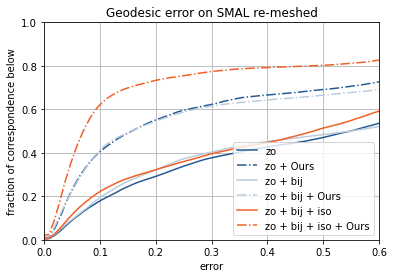

In [48]:
# plot all errors

####################################### Standard Zoomout

maps=Z
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo', color='#255995')
maps=ZQ
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo + Ours', linestyle='dashdot', color='#255995')

####################################### Bijective Zoomout

maps=BZ
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo + bij', color='#bbccdd')
maps=BZQ
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo + bij + Ours', linestyle='dashdot', color='#bbccdd')

####################################### Bijective & Isometric Zoomout

maps=BZI
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo + bij + iso', color='#f25f25')
maps=BZIQ
plt.plot(np.sort(maps), np.linspace(0, 1, len(maps)),
         label='zo + bij + iso + Ours', linestyle='dashdot', color='#f25f25')



plt.xlabel('error')
plt.ylabel('fraction of correspondence below')
plt.axis([0,0.6,0,1])
plt.legend(loc = 'lower right')
plt.grid()

plt.title('Geodesic error on SMAL re-meshed')
#plt.savefig('Geo_curves_SMAL.pdf')